# COVID-19 ML

This jupyter notebook analyses publically available data on COVID infections and deaths using the pandas data framework.

## Datasets
The raw COVID-19 data is published by European Centre for Disease Prevention and Control and can be downloaded daily from https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

Population data is taken from the World Bank (included in the dataset above).

Start by downloading the latest data:

In [39]:
!curl -O https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  386k  100  386k    0     0  1018k      0 --:--:-- --:--:-- --:--:-- 1018k


Read the data into a pandas Dataframe. Use the dateRep column as the index:

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide.xlsx").set_index("dateRep")

The dataset contains worldwide data on all countries. Note that each daily entry only the new cases/deaths for that day:

In [41]:
df

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
dateRep,,,,,,,,,
2020-04-06,6,4,2020,29,2,Afghanistan,AF,AFG,37172386.0
2020-04-05,5,4,2020,35,1,Afghanistan,AF,AFG,37172386.0
2020-04-04,4,4,2020,0,0,Afghanistan,AF,AFG,37172386.0
2020-04-03,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
2020-04-02,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...
2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0


In [42]:
# list of countries available in the data set
print("Number of countries: %d" % len(df["countriesAndTerritories"].unique()))
df["countriesAndTerritories"].unique()

Number of countries: 205


array(['Afghanistan', 'Albania', 'Andorra', 'Algeria', 'Angola',
       'Anguilla', 'Antigua_and_Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius and Saba', 'Bosnia_and_Herzegovina',
       'Botswana', 'Brazil', 'British_Virgin_Islands',
       'Brunei_Darussalam', 'Bulgaria', 'Burkina_Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape_Verde',
       'Cases_on_an_international_conveyance_Japan', 'Cayman_Islands',
       'Central_African_Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa_Rica', 'Cote_dIvoire', 'Croatia', 'Cuba',
       'CuraÃ§ao', 'Cyprus', 'Czech_Republic',
       'Democratic_Republic_of_the_Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican_Republic', 'Ecuador', 'Egypt',
       'El_Salvador', 'Equatorial_Guinea', 'Eritre

# Summary statistics by country
This section provides some basic summaries of the data.

## Total cases / deaths
Start with the recorded COVID-19 cases and deaths of worldwide and for some selected countries:

In [43]:
countries=["China", "Italy", "United_Kingdom", "Luxembourg", "United_States_of_America", "Spain", "Germany", "Austria"]

def print_df(df, label):
    df_c = df[["cases", "deaths"]].sum()
    print(label)
    print("\tcases: %s" % df_c["cases"])
    print("\tdeaths: %s" % df_c["deaths"])
    
# worldwide
print_df(df, "worldwide")
# for selected countries
for c in countries:
    print_df(df[df["countriesAndTerritories"] == c], c)


worldwide
	cases: 1244421
	deaths: 68976
China
	cases: 82642
	deaths: 3335
Italy
	cases: 128948
	deaths: 15889
United_Kingdom
	cases: 47806
	deaths: 4934
Luxembourg
	cases: 2804
	deaths: 36
United_States_of_America
	cases: 337635
	deaths: 9647
Spain
	cases: 130759
	deaths: 12418
Germany
	cases: 95391
	deaths: 1434
Austria
	cases: 11983
	deaths: 204


Now group the data set by country ready for the next section of country-based statistics:

In [44]:
# sum total of cases and deaths by country
cases_deaths_df = df.groupby(by="countriesAndTerritories")[["cases", "deaths"]].sum()
cases_deaths_df

,cases,deaths
countriesAndTerritories,,
Afghanistan,299,7
Albania,361,21
Algeria,1320,152
Andorra,501,18
Angola,14,2
...,...,...
Uzbekistan,342,2
Venezuela,148,5
Vietnam,241,0


## Top 20 countries with highest recorded infection cases

Start with a simple plot of the overall infection numbers per country. This compares the absolute figures and does not take into account the population of a country.

### Remarks
Countries with larger populations appear higher in the lists simply as a result of the size.

Also, the statistics do not consider the different testing rates across countries (countries with more focussed testing policies will detect higher numbers of infections and vice-versa).

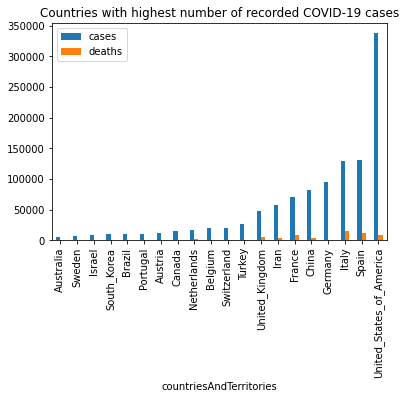

In [45]:
cases_deaths_df.sort_values("cases").tail(20).plot(kind="bar", y=["cases", "deaths"], title="Countries with highest number of recorded COVID-19 cases")
plt.savefig("docs/graphs/top20_infections.png")

## Top 20 countries with highest recorded mortalities
This graph shows those countries with the highest number of COVID-19 deaths.
Again, the figures are presented directly without any scaling to take into account the population size (see below for mortality rates).

Note also that the policies for recording a COVID-19 death are not consistent across countries. Some countries record any the death in the COVID statistics if the deceased had contracted COVID-19 while other countries only record the death if the COVID-19 was deemed to be the underlying cause.

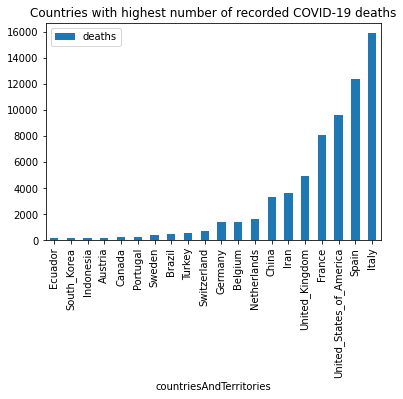

In [46]:
cases_deaths_df.sort_values("deaths").tail(20).plot(kind="bar", y=["deaths"], title="Countries with highest number of recorded COVID-19 deaths")
plt.savefig("docs/graphs/top20_mortalities.png")

## Top 20 countries with highest COVID-19 infection and mortality rates
This graph adjusts for population size by expressing all cases and deaths in terms of the underlying population size (i.e. infection/mortality rates).
While many of the hotspot countries (Italy, Spain) are still present, some of the larger countries no longer appear in the graphs (notably USA: while the recorded infections are far higher than any other countries, this is still lower when population size is taken into consideration).

Countries on the very right are those that yet to record any cases and/or deaths.

As before, differences in testing policies and recording deaths will skew the statistics.

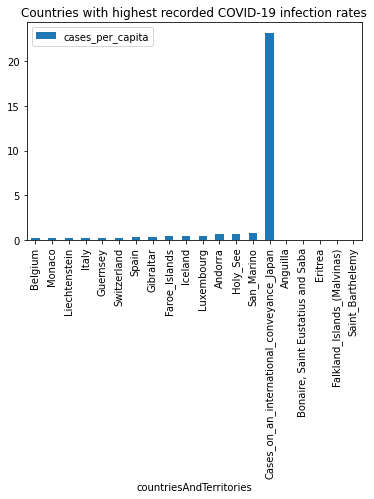

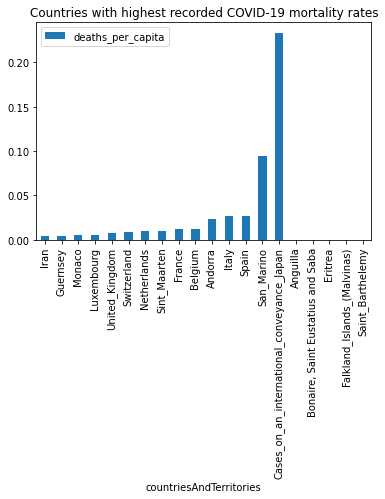

In [47]:
# top 20 worst pop/death and pop/cases ratios
cases_deaths_df = cases_deaths_df.join(df.set_index("countriesAndTerritories")["popData2018"].drop_duplicates(), rsuffix="right")
cases_deaths_df["cases_per_capita"] = cases_deaths_df["cases"] / cases_deaths_df["popData2018"] * 100
cases_deaths_df["deaths_per_capita"] = cases_deaths_df["deaths"] / cases_deaths_df["popData2018"] * 100

cases_deaths_df.sort_values("cases_per_capita").tail(20).plot(kind="bar", y="cases_per_capita", title="Countries with highest recorded COVID-19 infection rates")
cases_deaths_df.sort_values("deaths_per_capita").tail(20).plot(kind="bar", y="deaths_per_capita", title="Countries with highest recorded COVID-19 mortality rates")


## Case Fatality Rates (CFR)
This metric calculates the proportion of deaths compared to the recorded cases. It describes the likelihood of an infection being fatal.

While this removes the bias against population sizes, the figures are still subject to the same issues relating from the recording of the raw data (level of testing; classification of death as COVID-related etc). Unlike the Infection Fatality Rate, these graphs only use recorded cases and do not try to take account of undiagnosed cases.

### Remarks
The majority of top countries are under-developed nations. This may indicate limitations in the health care systems (where a COVID infection has an increased risk of a fatality), and/or be a result of more limited testing programmes (which reduce the number of recorded infections).

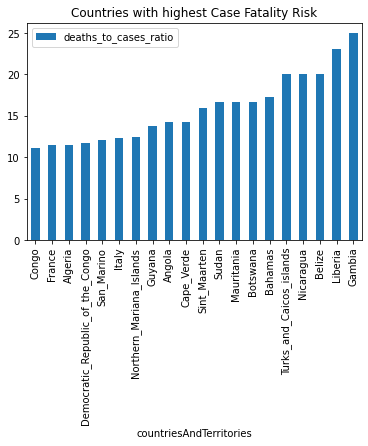

In [48]:
# top 20 worst death/cases ratios
cases_deaths_df["deaths_to_cases_ratio"] = cases_deaths_df["deaths"] / cases_deaths_df["cases"] * 100
ax = cases_deaths_df.sort_values("deaths_to_cases_ratio").tail(20).plot(kind="bar", y="deaths_to_cases_ratio", title="Countries with highest Case Fatality Risk")

# Evolution of COVID-19
The following graphs look at how the COVID-19 infection rate is changing over time.
This can identify peak infection rates (where the number of new infections is at its highest) and show how these vary across countries.

The graphs also show how infection curves flatten (how quickly the number of new cases reduces).

## Cumulative infections and mortalities
These graphs show how the total number of COVID-19 infections/deaths has evolved over time for some selected countries.

Note how the gradients of the curves - indicating the infection/mortality rates - vary across countries.
As the rate of infection decreases, the curves starts to flatten (eventually flattenning completely as no new cases are discovered).

### Remarks
Both Spain and the United States have noticeably steeper infection curves (while the gradients of mortalities are broadly similar).

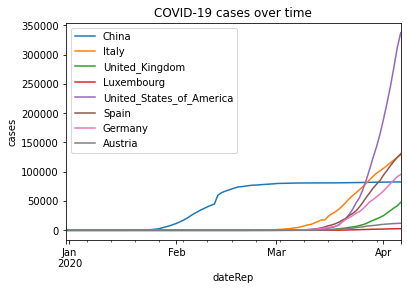

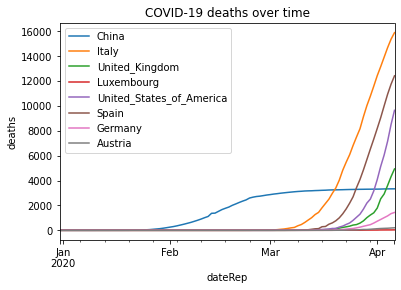

In [49]:
# COVID-19 cases for selected countries (unscaled)
ax_cases = None
ax_deaths = None

for c in countries:
    # transform daily delta into cumulative
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    ax_cases = df_c.plot(ax=ax_cases, y="cases", title="COVID-19 cases over time")
    ax_deaths = df_c.plot(ax=ax_deaths, y="deaths", title="COVID-19 deaths over time")
    
ax_cases.set_ylabel("cases")
ax_cases.legend(countries)
ax_deaths.set_ylabel("deaths")
ax_deaths.legend(countries)
plt.savefig("docs/graphs/covid_tot_cases.png")
plt.savefig("docs/graphs/covid_tot_deaths.png")

## Infection and mortality rates over time
These graphs show the numbers of infections and mortalities as a percentage of the underlying population.
This takes account of population size and allows figures to be compared across countries.

As before, any variations in data collection methods, testing policies etc will skew the statistics.

### Remarks
Figures for Luxembourg show a very high infection rate as a percentage of the overall population. This is generally due to the figure being used as the population: the active working population is many times higher than the actual number of residents due to the high daily influx of frontier workers. These clearly impact infection rates but are not taken into account in the statistics.

While infection numbers for Spain and Italy are broadly similar, the infection for Italy is comparatively lower due to the larger population. Note also how infection was slower to take hold (or at least, as reflected in the recorded figures), but increased more rapidly.

<Figure size 432x288 with 0 Axes>

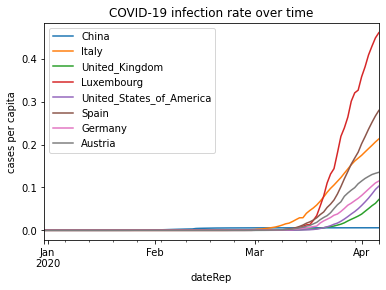

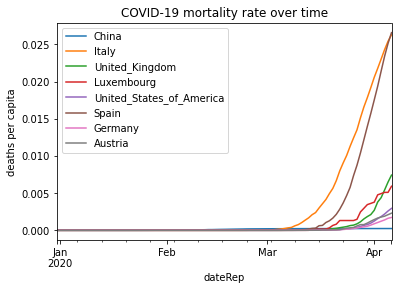

In [54]:
# COVID-19 cases/deaths for selected countries (scales as rates per capita)
fig = plt.figure()
fig.tight_layout()

plot_data = {}

# prepare the data separately from plotting
for c in countries:
    # transform daily delta into cumulative cases and deaths
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    # lookup population from raw data (no join because missing country)
    population = df[df["countriesAndTerritories"] == c]["popData2018"].iloc[0]
    
    df_c["cases_rate"] = df_c["cases"] / population * 100
    df_c["deaths_rate"] = df_c["deaths"] / population * 100
    
    # store the data in a dictionary
    plot_data[c] = df_c

# plot infection rates
ax_cases = None
for c, df_c in plot_data.items():
    ax_cases = df_c.plot(ax=ax_cases, y="cases_rate", title="COVID-19 infection rate over time", legend=False)
ax_cases.set_ylabel("cases per capita")
ax_cases.legend(plot_data.keys())
plt.savefig("docs/graphs/infection_rates_over_time.png")

# plot mortality rates
# plot infection rates
ax_deaths = None
for c, df_c in plot_data.items():
    ax_deaths = df_c.plot(ax=ax_deaths, y="deaths_rate", title="COVID-19 mortality rate over time")
ax_deaths.set_ylabel("deaths per capita")
ax_deaths.legend(plot_data.keys())
plt.savefig("docs/graphs/mortality_rates_over_time.png")

## Daily infections and deaths
These graphs show the number of new infections and deaths each day. This is the way the raw data is presented in the downloaded file.

These figures show the delta changes per day and correspond to the gradient of the earlier graphs (the 1st derivative). As the infection rate slows, the number of new daily cases will decrease, eventually tending to zero. Conversely, the delta changs are at their highest when the gradient of the earlier graphs are steepest. This corresponds to when the speed of infection is at its highest.

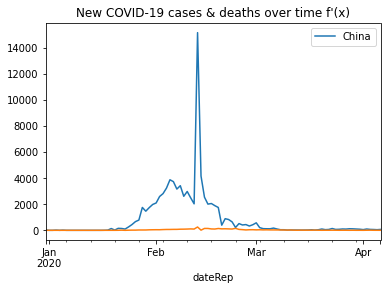

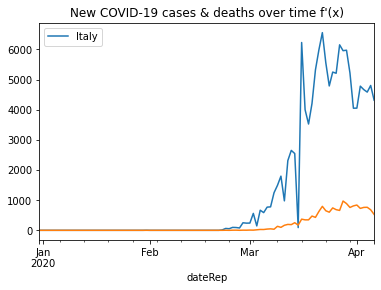

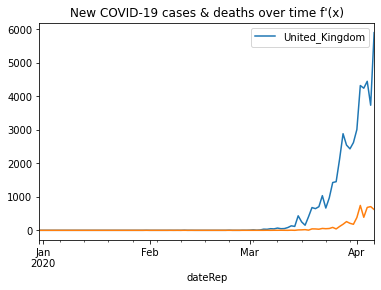

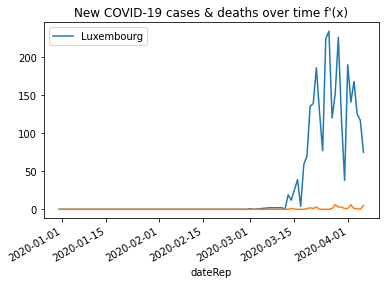

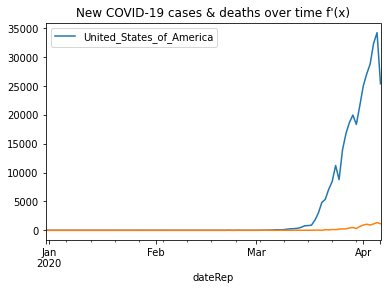

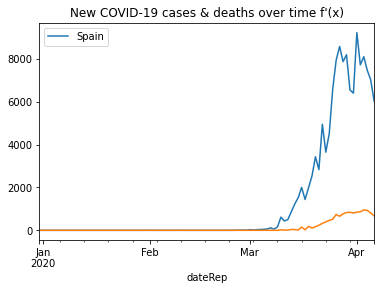

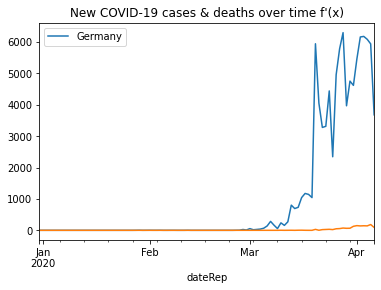

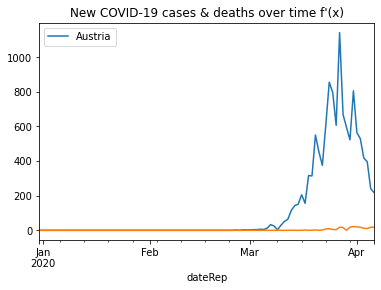

In [51]:
# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country
# This is the original form of the data and shows increase/decrease in infections/deaths.
# Useful to identify then the daily increase reaches a maximum and starts to drop (gradient of the curve = 0)
ax = None
for c in countries:
    # no need to transform, just sort on date
    ax = df[df["countriesAndTerritories"] == c].sort_index().plot(y=["cases", "deaths"], title="New COVID-19 cases & deaths over time f'(x)")
    ax.legend([c])
    plt.savefig("docs/graphs/covid_derivative_%s.png" % c)

# Unused

Text(0, 0.5, 'deaths')

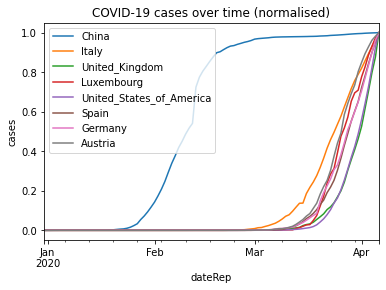

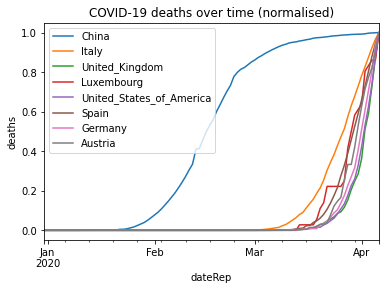

In [52]:
# COVID-19 cases for selected countries (normalise 0-1)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

ax_cases = None
ax_deaths = None

# extract data for each country
for c in countries:
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    # normalise the values 0-1
    np_scaled = min_max_scaler.fit_transform(df_c)
    df_c_normalized = pd.DataFrame(np_scaled, columns=df_c.columns, index=df_c.index)
    
    ax_cases = df_c_normalized.plot(ax=ax_cases, y="cases", title="COVID-19 cases over time (normalised)")
    ax_deaths = df_c_normalized.plot(ax=ax_deaths, y="deaths", title="COVID-19 deaths over time (normalised)")

ax_cases.legend(countries)
ax_cases.set_ylabel("cases")
ax_deaths.legend(countries)
ax_deaths.set_ylabel("deaths")

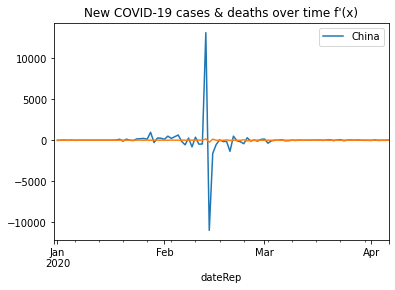

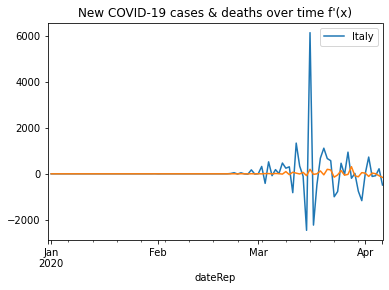

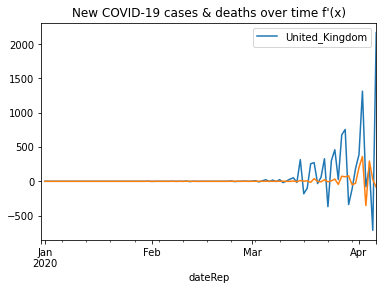

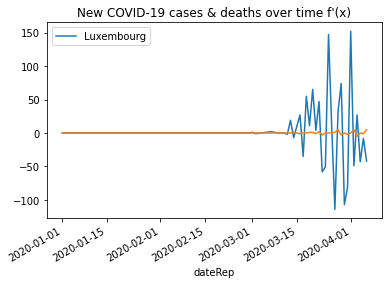

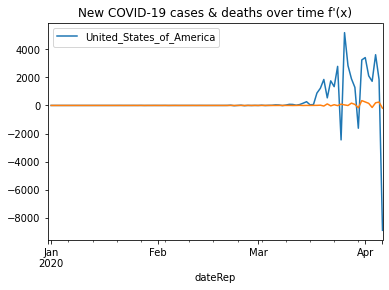

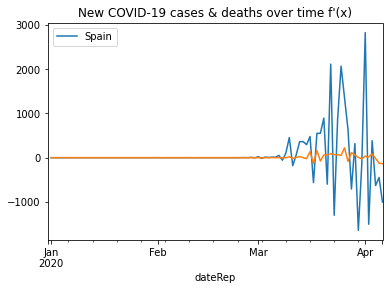

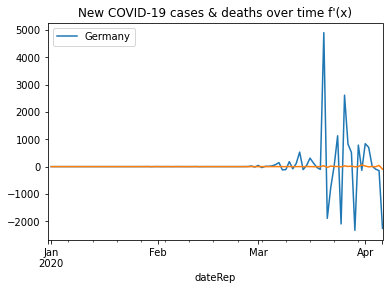

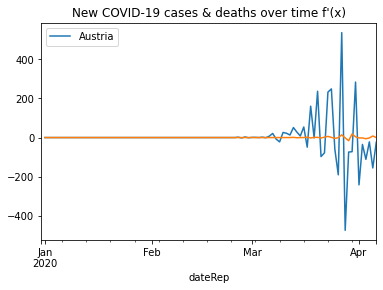

In [53]:
# 2nd derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country
# Shows when the infection rates increase/decrease
ax = None
for c in countries:
    # transform daily delta into cumulative
    ax = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().diff(axis=0).plot(title="New COVID-19 cases & deaths over time f'(x)")
    ax.legend([c])
    #plt.savefig("docs/graphs/covid_derivative2_%s.png" % c)